In [1]:
#%pip install scikit-learn

In [2]:
import os
import pandas as pd
import sys


def read_csv(filename="water_consumption_updated.csv", delimiter=";"):
    if not os.path.exists(filename):
        print(f"File '{filename}' does not exist.")
        sys.exit(1)

    df = pd.read_csv(filename, delimiter=delimiter)
    if "Consumption" in df.columns:
        df["Consumption"] = pd.to_numeric(df["Consumption"].str.replace(",", "."))
        df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
        df["Day"] = pd.to_numeric(df["Day"], errors="coerce")

    if "Area" in df.columns:
        df["Area"] = pd.to_numeric(df["Area"].str.replace(",", "."), errors="coerce")

    if df.empty or len(df) == 1:
        raise ValueError("Empty file or file with only header.")
    return df


In [3]:
def calculate_monthly_cost(data):
    data["MonthlyCost"] = data["Consumption"].apply(
        lambda x: x * 0.7 if x <= 1000 else 1000 * 0.7 + (x - 1000) * 0.7 * 1.15)
    return data


def average_monthly_cost(data):
    return data.groupby("Park")["MonthlyCost"].mean()


In [4]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


def predict_cost():
    # Read the data
    df = read_csv("water_consumption_updated.csv")
    areas = read_csv("Area.csv")

    # Merge the consumption data with the area data
    df = pd.merge(df, areas, on="Park", how="left")

    # Group the data by park and month, and calculate the total consumption for each month
    df["MonthYear"] = pd.to_datetime(df['Year'].astype(str) + df['Month'].astype(str), format='%Y%m')
    df = df.groupby(["Park", "MonthYear"])["Consumption"].sum().reset_index()

    # Calculate the monthly cost for each park
    df = calculate_monthly_cost(df)

    # Calculate the average cost per park
    average_costs = average_monthly_cost(df)

    # Convert the average_costs Series to a DataFrame
    average_costs = average_costs.reset_index()
    average_costs.columns = ["Park", "AverageCost"]

    # Merge the average costs with the area data
    data = pd.merge(areas, average_costs, on="Park")

    # Perform a linear regression
    X = data["Area"].values.reshape(-1, 1)
    y = data["AverageCost"]
    model = LinearRegression().fit(X, y)

    # Predict the average monthly cost
    new_park_area = 55
    predicted_cost = model.predict([[new_park_area]])
    print(f"The predicted average monthly cost for a 55-hectare park is {predicted_cost[0]:.2f}€")

    # Plot the actual data and the predicted data
    print("Plotting the actual data and the predicted regression line...")
    plt.scatter(data["Area"], data["AverageCost"], color='blue')
    plt.plot(data["Area"], model.predict(X), color='red')
    plt.title('Actual Data and Predicted Regression Line')
    plt.xlabel('Area')
    plt.ylabel('Average Cost')
    plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def polynomial_regression():
    # Load the data from the file
    data = pd.read_csv("execution_times.csv", sep=";")

    # Extract the input size and execution time from the data
    input_size = data['size'].values.reshape(-1, 1)
    data['time'] = data['time'].astype(float)
    data['time'] = data['time'] / 1000  # Convert time to seconds
    execution_time = data['time'].values

    # Perform polynomial regression
    poly_features = PolynomialFeatures(degree=2) 
    input_size_poly = poly_features.fit_transform(input_size)

    model = LinearRegression()
    model.fit(input_size_poly, execution_time)

    # Make predictions
    execution_time_pred = model.predict(input_size_poly)

    # Evaluate the model
    mse = mean_squared_error(execution_time, execution_time_pred)
    r2 = r2_score(execution_time, execution_time_pred)

    # Visualize the data and the fitted curve
    plt.scatter(input_size, execution_time, color='blue', label="Actual Data")
    plt.plot(input_size, execution_time_pred, color='red', label="Fitted Curve")
    plt.title("Polynomial Regression")
    plt.xlabel("Input Size")
    plt.ylabel("Execution Time")
    plt.legend()
    plt.show()

    print(f"Mean Squared Error: {mse*100:.2f}%")
    print(f"R-squared: {r2*100:.2f}%")

-x-x-x-x-x-x- MENU -x-x-x-x-x-x-x-
1. Average park cost
2. Polynomial Regression
9. Exit Application
The predicted average monthly cost for a 55-hectare park is 1934.17€
Plotting the actual data and the predicted regression line...


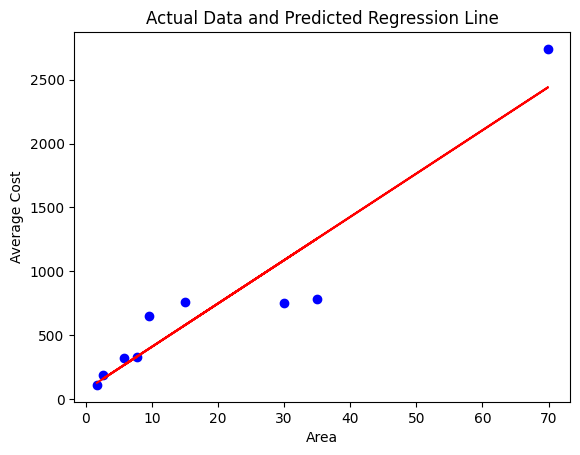

-x-x-x-x-x-x- MENU -x-x-x-x-x-x-x-
1. Average park cost
2. Polynomial Regression
9. Exit Application


In [6]:
def menu():
    while True:
        print("-x-x-x-x-x-x- MENU -x-x-x-x-x-x-x-")
        print("1. Average park cost")
        print("2. Polynomial Regression")
        print("9. Exit Application")
        choice = input("Enter your choice: ")

        match choice:
            case "1":
                predict_cost()
            case "2":
                polynomial_regression()
            case "9":
                print("Exiting Application")
                return 
            case _:
                print("Invalid choice")


menu()